# Chad Rainfall Analysis 2011

This notebook will be analysing daily rainfall in Chad for 2011 using CHIRPS satellite data. 

Due to the fact that Chad is a semi-arid climate, I identify the thresholds as:

**Drought Periods**: Days where the 7 day rolling average rainfall falls below the 10th percentile threshold.  
**Extreme Rainfall Events**: Peaks of daily rainfall above the 90th percentile threshold.

The analysis is performed first on **N'Djamena** and then extended to the **entire country**.

Below is importing the libraries required to complete this data analysis as well as loading the CHIRPS daily global rainfall for 2011 and inspect its dimensions and variables.

In [50]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import geopandas as gpd
import geodatasets as gd
import rioxarray


ds = xr.open_dataset("C:\Projects\geodataprojects\data\chirps_global_2011.nc")
ds

<xarray.Dataset> Size: 841MB
Dimensions:    (latitude: 400, longitude: 1440, time: 365)
Coordinates:
  * latitude   (latitude) float32 2kB -49.88 -49.62 -49.38 ... 49.38 49.62 49.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time       (time) datetime64[ns] 3kB 2011-01-01 2011-01-02 ... 2011-12-31
Data variables:
    precip     (time, latitude, longitude) float32 841MB ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-10-07
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

## Subset Chad and N'Djamena

With the data of daily rainfall globally in 2011, I am going to subset **Chad** with the coordinates of 7°N to 24°N, 14°E to 24°E so that I can use the rain data for only the specific country and then select a coordinate point of 12.1°N, 15°E for **N'Djamena**. 

Due to the nature of the CHIRPS dataset, the selected values will have to be on the grid and so the coordinates have been adjusted accordingly, but still is within N'Djamena.

N’Djamena is extracted from the Chad subset to ensure spatial consistency between point-level and country-level analyses.

In [51]:
lat_min, lat_max = 7.0, 24.0
long_min, long_max = 14.0, 24.0

chad = ds.sel(
    latitude = slice(lat_min, lat_max),
    longitude = slice(long_min, long_max)
)

lat_point = chad.latitude.sel(latitude=12.125, method="nearest")
long_point = chad.longitude.sel(longitude=15.125, method="nearest")

ndjamena_rain = chad["precip"].sel(
    latitude = lat_point,
    longitude = long_point,
)

dataframe_ndjamena = ndjamena_rain.to_dataframe().reset_index()
total_days = len(dataframe_ndjamena)
dry_days = (dataframe_ndjamena["precip"] == 0).sum()
print(f"{dry_days}/{total_days} days have no rainfall ({dry_days/total_days*100:.1f}%)")

267/365 days have no rainfall (73.2%)


## Calculating Setup for the visualisation of the dataset

### 7-Day Rolling Average

To identify sustained dry or wet periods, I calculate a **7-day rolling average** of daily precipitation to:

- Smooths out daily variability
- Helps detect droughts over multiple days rather than single dry days

### Drought and Extreme Rainfall Thresholds

I define thresholds to flag extreme events as:

- **Drought threshold**: 10th percentile of the 7-day rolling average.  
- **Extreme rainfall threshold**: 90th percentile of daily precipitation.

These thresholds are adjusted from standard 5%/95% to account for Chad's semi-arid climate.

### Flagging Drought and Extreme Events

I create boolean columns to mark:

- **`is_drought`** → True if the 7-day rolling average is below the drought threshold  
- **`is_extreme`** → True if daily precipitation is above the extreme rainfall threshold

In [52]:
dataframe_ndjamena["rainfall_7day_avg"] = dataframe_ndjamena["precip"].rolling(7, min_periods=1).mean()

drought_threshold = dataframe_ndjamena["rainfall_7day_avg"].quantile(0.10)
dataframe_ndjamena["is_drought"] = dataframe_ndjamena["rainfall_7day_avg"] < drought_threshold

extreme_threshold = dataframe_ndjamena["precip"].quantile(0.90)
dataframe_ndjamena["is_extreme"] = dataframe_ndjamena["precip"] > extreme_threshold

## Visualizing Droughts and Extreme Rainfall

I plot a single graph combining:

- Daily rainfall (light gray)  
- 7-day rolling average (orange line)  
- Drought periods (red dots)  
- Extreme rainfall events (blue dots)  
- Threshold lines (dashed red/blue)

This helps visualize both prolonged dry periods and rare intense rainfall events.

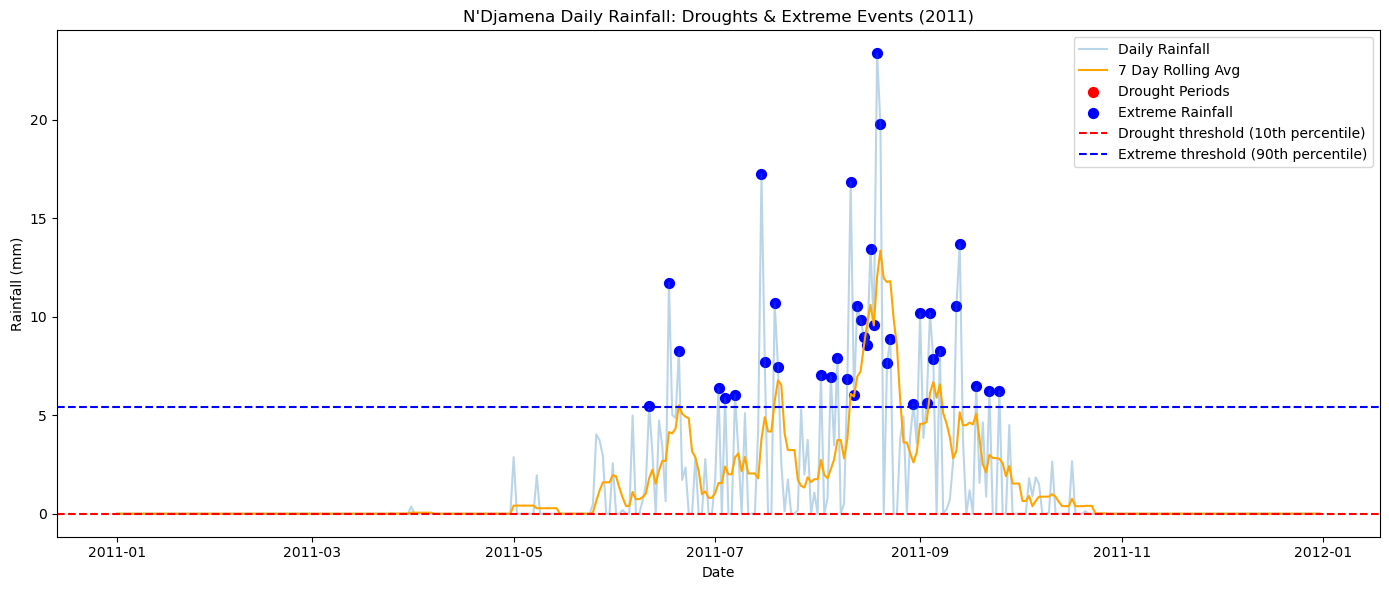

In [53]:
plt.figure(figsize=(14,6))

plt.plot(dataframe_ndjamena["time"], dataframe_ndjamena["precip"], alpha=0.3, label="Daily Rainfall")
plt.plot(dataframe_ndjamena["time"], dataframe_ndjamena["rainfall_7day_avg"], color="orange", label="7 Day Rolling Avg")

plt.scatter(
    dataframe_ndjamena.loc[dataframe_ndjamena["is_drought"], "time"],
    dataframe_ndjamena.loc[dataframe_ndjamena["is_drought"], "rainfall_7day_avg"],
    color = "red",
    label = "Drought Periods",
    s = 50
)

plt.scatter(
    dataframe_ndjamena.loc[dataframe_ndjamena["is_extreme"], "time"],
    dataframe_ndjamena.loc[dataframe_ndjamena["is_extreme"], "precip"],
    color = "blue",
    label = "Extreme Rainfall",
    s = 50
)

plt.axhline(drought_threshold, linestyle="--", color="red", label="Drought threshold (10th percentile)")
plt.axhline(extreme_threshold, linestyle="--", color="blue", label="Extreme threshold (90th percentile)")

plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.title("N'Djamena Daily Rainfall: Droughts & Extreme Events (2011)")
plt.legend()
plt.tight_layout()
plt.show()

## Summary Statistics

I calculate the number and proportion of:

- **Drought days**  
- **Extreme rainfall days**

This quantifies the frequency of these events in N'Djamena over the year 2011.

In [54]:
num_drought_days = dataframe_ndjamena["is_drought"].sum()
num_extreme_days = dataframe_ndjamena["is_extreme"].sum()
total_days = len(dataframe_ndjamena)

print(f"Drought days: {num_drought_days} ({num_drought_days/total_days*100:.1f}% of year)")
print(f"Extreme rainfall days: {num_extreme_days} ({num_extreme_days/total_days*100:.1f}% of year)")


Drought days: 0 (0.0% of year)
Extreme rainfall days: 37 (10.1% of year)


## Extending Analysis to the Entire Country

While the N'Djamena analysis illustrates the workflow for a single location, it has some limitations:

- N'Djamena is semi arid, so most of the year has zero rainfall. Using a percentile based method over the full year does not flag any drought days.  
- In semi arid climates, sustained periods of 0 mm rainfall should be considered drought by default.

For the **entire country**, additional challenges arise:

- Northern Chad is desert and has almost no rainfall year-round.  
- Averaging across all grid cells would bias the analysis toward the desert climate, hiding meaningful droughts in more humid areas.

To address this, I compute **drought and extreme rainfall thresholds per grid cell**, rather than using a country wide average. This allows me to:

- Detect droughts meaningfully across all regions, including areas that normally receive rainfall.  
- Identify extreme rainfall events relative to the local climate.  

Below, I apply this approach to the CHIRPS data for the entire country, using **7 day rolling averages per grid cell for drought detection** and **daily precipitation per grid cell for extreme rainfall events**. On top of this, when it comes to droughts I will specifically check for consecutive days where **rainfall < 1mm**.


In [55]:
dataframe_chad = chad.to_dataframe().reset_index()
dataframe_chad = dataframe_chad.sort_values(by=["latitude", "longitude", "time"])

dataframe_chad["rainfall_7day_avg"] = dataframe_chad.groupby(["latitude", "longitude"])["precip"].transform(lambda x: x.rolling(7, min_periods=1).mean())


## Drought and Extreme Rainfall Thresholds per gridcell

I define thresholds to flag extreme events as so:

- **Drought threshold**: Experiences >= 7 consecutive days with daily rainfall < 1mm  
- **Extreme rainfall threshold**: 90th percentile of daily precipitation.

### Flagging Drought and Extreme Events

I create boolean columns to mark:

- **`is_drought`** → True if the dry spell length is greater than 7 
- **`is_extreme`** → True if daily precipitation is above the extreme rainfall threshold

In [56]:
daily_threshold = 1.0

dataframe_chad["is_dry"] = dataframe_chad["precip"] < daily_threshold
dataframe_chad["dry_spell_length"] = (
    dataframe_chad.groupby(["latitude", "longitude"])["is_dry"].apply(lambda x: x.groupby((~x).cumsum()).cumsum()).reset_index(level=[0, 1], drop=True)
)
dataframe_chad["is_drought"] = dataframe_chad["dry_spell_length"] >= 7

dataframe_chad["extreme_threshold"] = dataframe_chad.groupby(["latitude", "longitude"])["precip"].transform(lambda x: x.quantile(0.90))
dataframe_chad["is_extreme"] = dataframe_chad["precip"] > dataframe_chad["extreme_threshold"]

## Country-Level Drought and Extreme Rainfall Dynamics

To extend the analysis from a single location to the national scale, drought and extreme rainfall events are aggregated across all grid cells within Chad.

Rather than averaging rainfall over the entire country, thresholds are computed **per grid cell** to account for Chad’s strong climatic gradients:

- Northern regions are predominantly desert and receive little to no rainfall year-round.
- Southern regions experience a distinct wet season and are more sensitive to drought and extreme rainfall.

For each grid cell:
- **Droughts** are identified when the consecutive days of less than 1mm of rainfall is greater than 7.
- **Extreme rainfall events** are identified when daily precipitation exceeds the 90th percentile of that cell’s climatology.

The figure below shows, for each day in 2011:
- The number of grid cells experiencing drought conditions
- The number of grid cells experiencing extreme rainfall

This provides a country-wide perspective on the spatial extent and temporal clustering of extreme events, rather than focusing on isolated locations.

**NOTE**:  
Drought detection at the country scale uses a persistence based definition rather than percentiles.

In arid and semi arid climates, rainfall distributions are dominated by zero values, causing percentile based methods to fail.  
Here, droughts are defined as periods of **at least seven consecutive days with daily rainfall below 1 mm**, computed per grid cell.

This approach captures sustained dry conditions across both semi arid and desert regions of Chad.



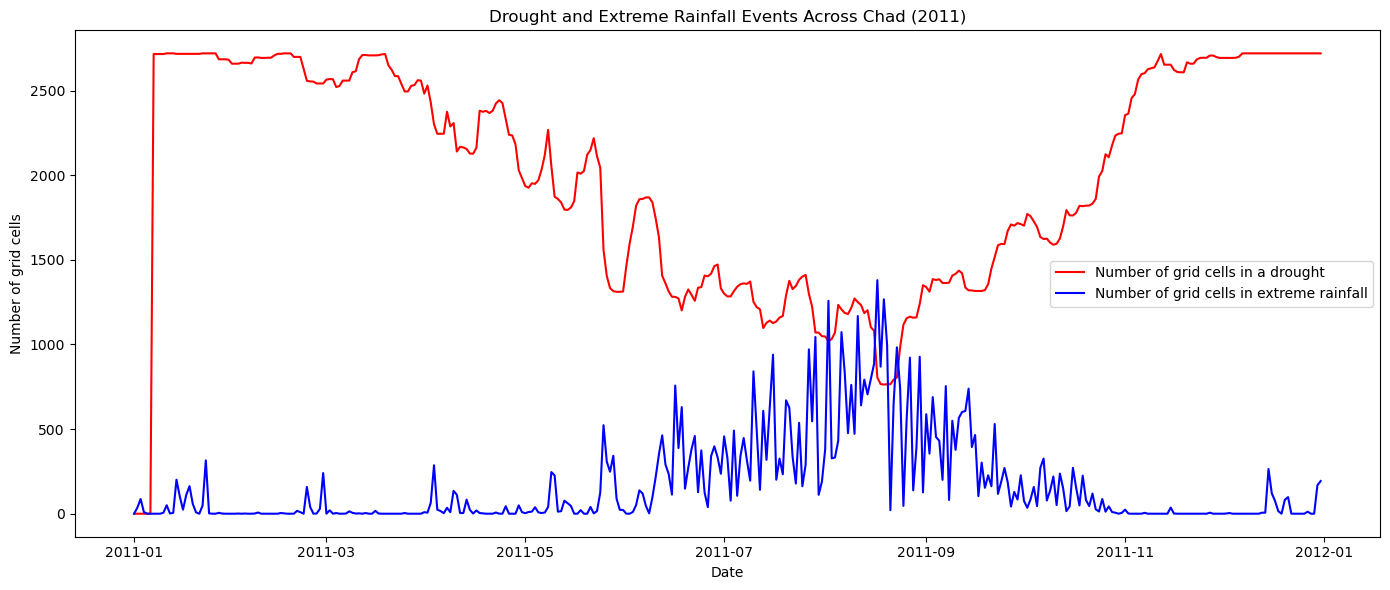

In [57]:
daily_summary = dataframe_chad.groupby("time")[["is_drought", "is_extreme"]].sum().reset_index()

plt.figure(figsize=(14,6))
plt.plot(daily_summary["time"], daily_summary["is_drought"], color="red", label="Number of grid cells in a drought")
plt.plot(daily_summary["time"], daily_summary["is_extreme"], color="blue", label="Number of grid cells in extreme rainfall")

plt.xlabel("Date")
plt.ylabel("Number of grid cells")
plt.title("Drought and Extreme Rainfall Events Across Chad (2011)")
plt.legend()
plt.tight_layout()
plt.show()

## Temporal rainfall behaviour and event identification

The time series analysis shows the highly seasonal nature of rainfall in Chad. Prolonged dry periods are much of the year with a short and intense wet season in the summer where the majority of the rainfall for the year occurs. 

Using percentile based thresholds applied to daily rainfall and rolling averages, extreme rainfall events and drought conditions were identified in the time domain. While this approach is effective for analysing rainfall variability at a single location or as an aggregated signal, it does not show how the rainfall or lack there of is spatially across the country.

To better the geographical pattern of drought in Chad, I will expand the analysis from a temporal perspective to a spatial one. The following section will visualise drought and conditions across Chad for a respective drought day as to examine the wetter parts of the country. This is also important as in semi arid environments nationally aggregated statistics can mask regional variability.

In [62]:
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
chad_shape = world[world["NAME"] == "Chad"]

daily_mean_precip = chad["precip"].mean(dim=["latitude", "longitude"])

drought_day_threshold = daily_mean_precip.quantile(0.10)

position = abs(daily_mean_precip - drought_day_threshold).argmin().item()

drought_date = daily_mean_precip["time"].isel(time=position).values
drought_map = chad["precip"].isel(time=position)
drought_mask = drought_map < 1.0

percentile_map = xr.apply_ufunc(
    lambda x, y: (x < y).mean(),
    chad["precip"],
    drought_map,
    input_core_dims=[["time"], []],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
)

percentile_map = percentile_map * 100
percentile_map = percentile_map.rio.write_crs("EPSG:4326")

percentile_clipped = percentile_map.rio.clip(
    chad_shape.geometry,
    chad_shape.crs,
    drop=True
)

bounds = [0, 5, 20, 100]

cmap = colors.ListedColormap(["darkred", "orange", "gold"])
norm = colors.BoundaryNorm(bounds, cmap.N)

## Spatial Distribution of Drought Conditions

To examine how drought conditions appear spatially across Chad, I selected a representative drought day based on national scale rainfall behaviour. Rather than using the absolute lowest rainfall day, as this would result in a uniformly dry map, I selected based off a percentile approach.

I specifically selected the day corresponding to the 10th percentile of spatially averaged rainfall, providing a realistic look at severe conditions of dry season while showing some spatial variety.

The way in which the categories will be assessed by colour goes as so:  
- **Red** sub 5% percentile rainfall  
- **Orange** 5%-20% percentile rainfall  
- **Yellow** over 20% percentile rainfall

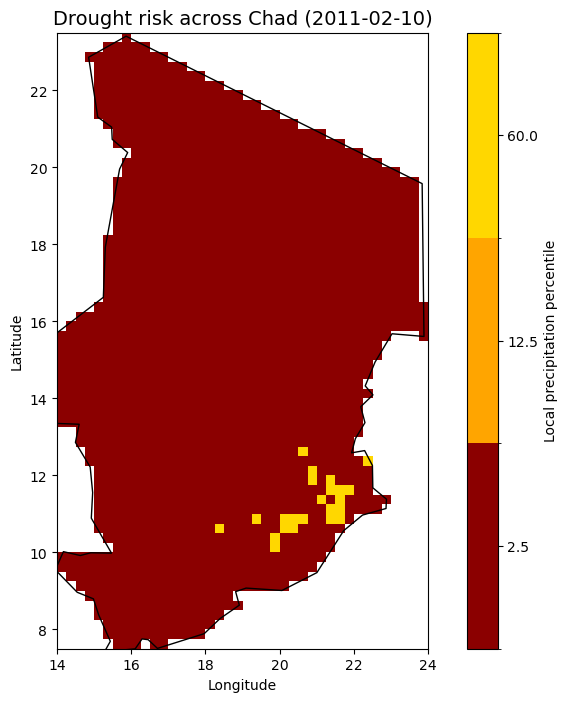

In [63]:
fig, ax = plt.subplots(figsize=(10, 8))

percentile_clipped.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    cbar_kwargs={
        "label": "Local precipitation percentile",
        "ticks": [2.5, 12.5, 60]
    }
)

chad_shape.boundary.plot(ax=ax, color="black", linewidth=1)

ax.set_title(
    f"Drought risk across Chad ({np.datetime_as_string(drought_date, unit='D')})",
    fontsize=14
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

### Interpretation

The resulting map shows that the majority of Chad experienced extreme drought conditions on this representative day, with most locations falling below the 5th percentile of their local historical precipitation distribution. This spatially coherent drought pattern is consistent with Chad’s predominantly arid climate and the seasonal dominance of dry conditions.

Despite the widespread dryness, localized areas particularly in the southeastern part of the country exhibit higher percentile values, indicating isolated convective rainfall events. This highlights the importance of using relative, location specific metrics when assessing drought risk, as absolute precipitation values alone would obscure meaningful spatial contrasts in climatologically dry regions.

Overall, this approach demonstrates how percentile‑based normalization allows drought risk to be assessed consistently across regions with strong climatic gradients.